In [1]:
#import packages
#feel free to import more if you need
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#evaluate the benign accuracy of a model
def test(model, x,y,batch_size):
    model.eval()
    total=x.shape[0]
    batches=np.ceil(total/batch_size).astype(int)
    success=0
    loss=0
    for i in range(batches):
        start_index=i*batch_size
        end_index=np.minimum((i+1)*batch_size,total)
        x_batch=torch.tensor(x[start_index:end_index]).float()
        y_batch=torch.tensor(y[start_index:end_index]).long()
        output=model(x_batch)
        pred=torch.argmax(output,dim=1)
        loss+=F.cross_entropy(output,y_batch).item()
        success+=(pred==y_batch).sum().item()
    #print ("accuracy: "+str(success/total))
    accuracy = success/total
    return accuracy


In [3]:
#define model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x=self.conv1(x)
        x=F.max_pool2d(x, 2)
        x = F.relu(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [87]:
#untargeted attack
#you may add parameters as you wish
# Reference (Recitation 3 Code)

def untargeted_attack(x, y, model_1, model_2, min_val, max_val):
    batch_size = 512
    num_batches = (len(x) + batch_size - 1) // batch_size
    accs = []
    models = [model_1, model_2]
    adv_imgs = []

    for model in models:
        all_accs = {}
        for eps in range(8, 64, 8):
            epsilon = eps

            adv_batch_x_all = np.zeros((len(x), x.shape[1], x.shape[2], x.shape[3]))
            print(adv_batch_x_all.shape)
            label_all = np.zeros((len(y),))

            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(x))
                batch_x = torch.tensor(x[start_idx:end_idx]).float()
                batch_y = torch.tensor(y[start_idx:end_idx]).long()
                adv_batch_x = batch_x.detach().clone()

                for _ in range(20):
                    adv_batch_x.requires_grad = True
                    pred = model(adv_batch_x)
                    #pred_B = model_2(adv_batch_x)
                    model.zero_grad()
                    #model_2.zero_grad()
                    loss = -nn.CrossEntropyLoss()(pred, batch_y)
                    loss.backward()
                    #loss_B = -nn.CrossEntropyLoss()(pred_B, batch_y)
                    #loss_B.backward()
                    grads = adv_batch_x.grad
                    with torch.no_grad():
                        adv_batch_x = adv_batch_x - epsilon * grads.sign()
                        eta = torch.clamp(adv_batch_x - batch_x, min=-epsilon, max=epsilon)
                        adv_batch_x = torch.clamp(batch_x + eta, min=min_val, max=max_val).detach().clone()
                        #adv_batch_x = torch.round(adv_batch_x*255)/255

                adv_batch_x_all[start_idx:end_idx] = adv_batch_x.numpy()
                label_all[start_idx:end_idx] = batch_y.numpy()

            adv_imgs.append(adv_batch_x_all[0])
            accuracy = test(model, adv_batch_x_all, label_all, 512)
            #accuracy_B = test(model_2, adv_batch_x_all, label_all, 512)
            all_accs[eps] = accuracy

        accs.append(all_accs)

    return accs

In [88]:
#load MNIST
dataset_train = datasets.MNIST('../data', train=True, download=True)
dataset_test = datasets.MNIST('../data', train=False, download=True)

# reshape MNIST
x_train=dataset_train.data.numpy()
y_train=dataset_train.targets.numpy()
x_test=dataset_test.data.numpy()
y_test=dataset_test.targets.numpy()
x_train=np.reshape(x_train,(60000,28,28,1))
x_test=np.reshape(x_test,(10000,28,28,1))
x_train=np.swapaxes(x_train, 1, 3)
x_test=np.swapaxes(x_test, 1, 3)


#REMINDER: the range of inputs is different from what we used in the recitation
print (x_test.min(),x_test.max())

modelA=Net()
modelA.load_state_dict(torch.load("modelA.zip"))
#accuracy_A_no_attack = test(modelA,x_test,y_test,512)
modelB=Net()
modelB.load_state_dict(torch.load("modelB.zip"))
#accuracy_B_no_attack = test(modelB,x_test,y_test,512)

0 255


<All keys matched successfully>

In [89]:
# Task - 1 - Untargeted attack

all_accs_task_1, adv_imgs_task_1 = untargeted_attack(x_test, y_test, modelA, modelB, x_test.min(), x_test.max())
print(all_accs_task_1)

(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
(10000, 1, 28, 28)
{8: 0.9552, 16: 0.7107, 24: 0.4436, 32: 0.2437, 40: 0.1297, 48: 0.0749, 56: 0.0458}


In [21]:
#targeted attack
#you may add parameters as you wish
def targeted_attack(x, y, model_1, model_2, min_val, max_val):
    #TODO
    
    alpha = 10
    batch_size = 512
    num_batches = (len(x) + batch_size - 1) // batch_size
    accs = []
    adv_imgs = []
    models = [model_1, model_2]

    for model in models:
        all_accs = {}
        for eps in range(8, 64, 8):
            #epsilon = eps / 255.
            epsilon = eps

            adv_batch_x_all = np.zeros((len(x), x.shape[1], x.shape[2], x.shape[3]))
            print(adv_batch_x_all.shape)
            label_all = np.zeros((len(y),))

            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(x))
                batch_x = torch.tensor(x[start_idx:end_idx]).float()
                batch_y = torch.tensor(y[start_idx:end_idx]).long()
                adv_batch_x = batch_x.detach().clone()
                target = torch.full((end_idx - start_idx,), 8, dtype=torch.long)
                m=torch.zeros(adv_batch_x.shape)
                v=torch.zeros(adv_batch_x.shape)

                for i in range(100):
                    adv_batch_x.requires_grad = True
                    pred = model(adv_batch_x)
                    model.zero_grad()
                    loss = nn.CrossEntropyLoss()(pred, target)
                    loss.backward()
                    grads = adv_batch_x.grad
                    with torch.no_grad():
                        t=i+1
                        m=0.9*m+0.1*grads
                        v=0.999*v+0.001*grads*grads
                        mhat=m/(1.0 - 0.9**t)
                        vhat=v/(1.0 - 0.999**t)
                        grads=mhat / (torch.sqrt(vhat) + 1e-8)
                        adv_batch_x = adv_batch_x - alpha * grads.sign()
                        eta = torch.clamp(adv_batch_x - batch_x, min=-epsilon, max=epsilon)
                        adv_batch_x = torch.clamp(batch_x + eta, min=min_val, max=max_val).detach().clone()

                adv_batch_x_all[start_idx:end_idx] = adv_batch_x.numpy()
                label_all[start_idx:end_idx] = batch_y.numpy()

            adv_imgs.append(adv_batch_x_all[0])
            accuracy = test(model_1, adv_batch_x_all, label_all, 512)
            #accuracy_B = test(model_2, adv_batch_x_all, label_all, 512)
            all_accs[eps] = accuracy

        accs.append(all_accs)

    return accs, adv_imgs

In [23]:
# Task - 2 - Targeted attack

indices_label_1 = np.where(y_test == 1)[0]
x_test_1s = x_test[indices_label_1]
y_test_1s = y_test[indices_label_1]
all_accs_task_2, adv_imgs_task_2 = targeted_attack(x_test_1s, y_test_1s, modelA, modelB, x_test_1s.min(), x_test_1s.max())
print(all_accs_task_2)

(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
[{8: 0.9841409691629956, 16: 0.5612334801762114, 24: 0.000881057268722467, 32: 0.0, 40: 0.0, 48: 0.0, 56: 0.0}, {8: 0.9938325991189427, 16: 0.9938325991189427, 24: 0.9876651982378855, 32: 0.9674008810572687, 40: 0.918942731277533, 48: 0.8088105726872247, 56: 0.628193832599119}]


In [24]:
def targeted_attack_improved(x, y, model_1, model_2, min_val, max_val):
    #TODO
    
    #alpha = 1.5
    #weight_decay = 1e-4
    batch_size = 512
    num_batches = (len(x) + batch_size - 1) // batch_size
    accs = []
    models = [model_1, model_2]
    adv_imgs = []

    for model in models:
        all_accs = {}
        for eps in range(8, 64, 8):
            #epsilon = eps / 255.
            epsilon = eps

            adv_batch_x_all = np.zeros((len(x), x.shape[1], x.shape[2], x.shape[3]))
            print(adv_batch_x_all.shape)
            label_all = np.zeros((len(y),))

            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(x))
                batch_x = torch.tensor(x[start_idx:end_idx]).float()
                batch_y = torch.tensor(y[start_idx:end_idx]).long()
                adv_batch_x = batch_x.detach().clone()
                target = torch.full((end_idx - start_idx,), 8, dtype=torch.long)
                m=torch.zeros(adv_batch_x.shape)
                v=torch.zeros(adv_batch_x.shape)
                alpha = 10

                for i in range(100):
                    adv_batch_x.requires_grad = True
                    pred = model(adv_batch_x)
                    model.zero_grad()
                    loss = nn.CrossEntropyLoss()(pred, target)
                    loss.backward()
                    grads = adv_batch_x.grad
                    with torch.no_grad():
                        t=i+1
                        m=0.9*m+0.1*grads
                        v=0.999*v+0.001*grads*grads
                        mhat=m/(1.0 - 0.9**t)
                        vhat=v/(1.0 - 0.999**t)
                        grads=mhat / (torch.sqrt(vhat) + 1e-8)
                        adv_batch_x = adv_batch_x - alpha * grads.sign()
                        eta = torch.clamp(adv_batch_x - batch_x, min=-epsilon, max=epsilon)
                        adv_batch_x = torch.clamp(batch_x + eta, min=min_val, max=max_val).detach().clone()
                    
                    
                    #alpha = alpha / (2 ** (i//20))
                    alpha = alpha * 0.99
                    
                adv_batch_x_all[start_idx:end_idx] = adv_batch_x.numpy()
                label_all[start_idx:end_idx] = batch_y.numpy()

            adv_imgs.append(adv_batch_x_all[0])
            accuracy = test(model_1, adv_batch_x_all, label_all, 512)
            #accuracy_B = test(model_2, adv_batch_x_all, label_all, 512)
            all_accs[eps] = accuracy

        accs.append(all_accs)

    return accs, adv_imgs

In [25]:
# Task - 3 - Targeted attack - Optimized

all_accs_task_3, adv_imgs_task_3 = targeted_attack_improved(x_test_1s, y_test_1s, modelA, modelB, x_test_1s.min(), x_test_1s.max())
print(all_accs_task_3)

(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
(1135, 1, 28, 28)
[{8: 0.9744493392070485, 16: 0.5110132158590308, 24: 0.0, 32: 0.0, 40: 0.0, 48: 0.0, 56: 0.0}, {8: 0.9938325991189427, 16: 0.9929515418502203, 24: 0.9850220264317181, 32: 0.9744493392070485, 40: 0.9303964757709251, 48: 0.8140969162995595, 56: 0.6317180616740088}]


In [ ]:
epsilons = [8, 16, 24, 32, 40, 48, 56]
fig, axes = plt.subplots(2, 8, figsize=(20, 5), gridspec_kw={'hspace': 0.2, 'wspace': 0.5})
k = 0
for i in range(2):
    axes[i, 0].imshow(x_test[0].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title('Original')
    for j in range(len(epsilons)):
        axes[i, j+1].imshow(adv_imgs_task_1[k].reshape(28, 28), cmap='gray')
        axes[i, j+1].set_title(f'Epsilon: {epsilons[j]}')
        k += 1

fig.text(0.5, 0.94, 'Model "A" Images', ha='center', fontsize=12)
fig.text(0.5, 0.48, 'Model "B" Images', ha='center', fontsize=12)

Text(0.5, 0.48, 'Model "B" Images')

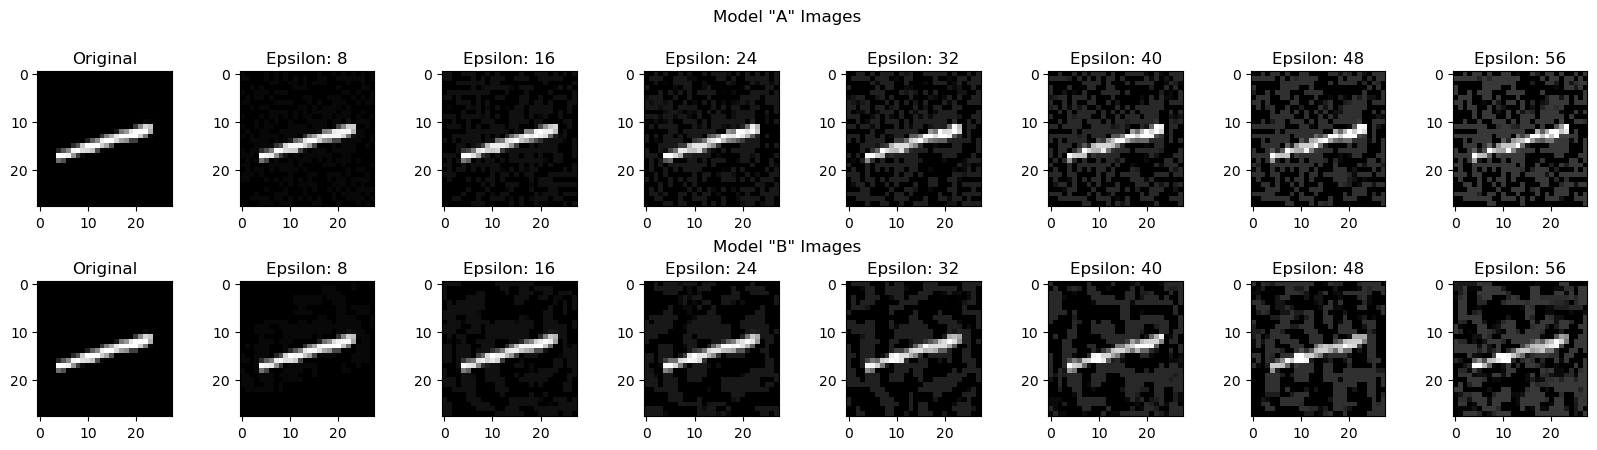

In [80]:
epsilons = [8, 16, 24, 32, 40, 48, 56]
fig, axes = plt.subplots(2, 8, figsize=(20, 5), gridspec_kw={'hspace': 0.2, 'wspace': 0.5})
k = 0
for i in range(2):
    axes[i, 0].imshow(x_test_1s[0].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title('Original')
    for j in range(len(epsilons)):
        axes[i, j+1].imshow(adv_imgs_task_2[k].reshape(28, 28), cmap='gray')
        axes[i, j+1].set_title(f'Epsilon: {epsilons[j]}')
        k += 1

fig.text(0.5, 0.94, 'Model "A" Images', ha='center', fontsize=12)
fig.text(0.5, 0.48, 'Model "B" Images', ha='center', fontsize=12)

Text(0.5, 0.48, 'Model "B" Images')

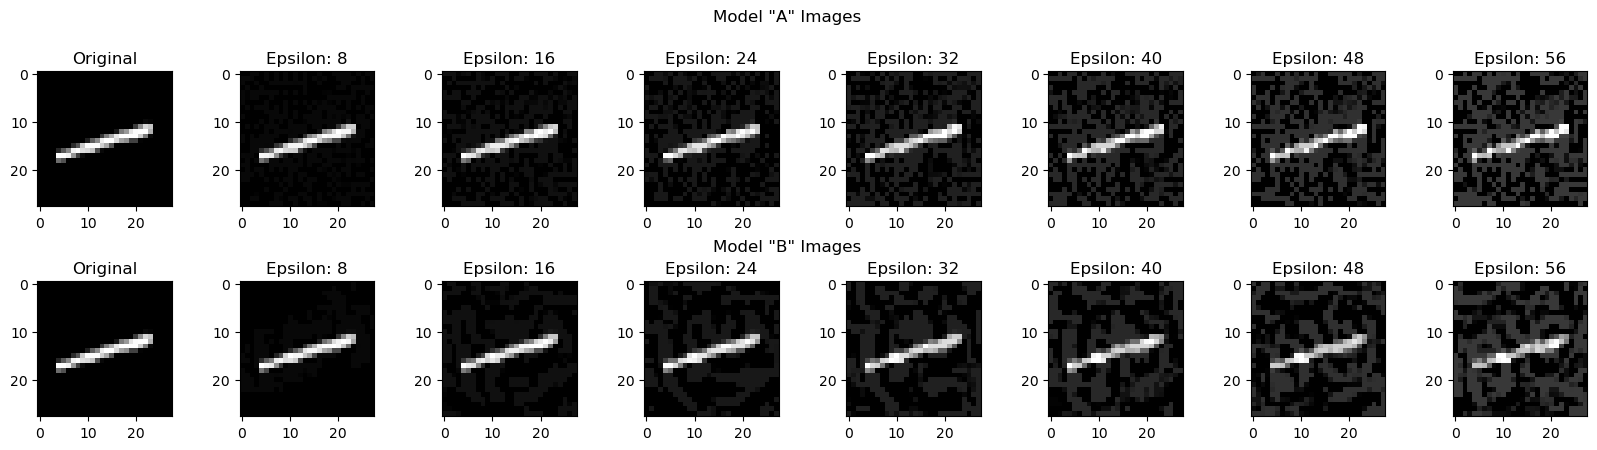

In [79]:
epsilons = [8, 16, 24, 32, 40, 48, 56]
fig, axes = plt.subplots(2, 8, figsize=(20, 5), gridspec_kw={'hspace': 0.2, 'wspace': 0.5})
k = 0
for i in range(2):
    axes[i, 0].imshow(x_test_1s[0].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title('Original')
    for j in range(len(epsilons)):
        axes[i, j+1].imshow(adv_imgs_task_3[k].reshape(28, 28), cmap='gray')
        axes[i, j+1].set_title(f'Epsilon: {epsilons[j]}')
        k += 1

fig.text(0.5, 0.94, 'Model "A" Images', ha='center', fontsize=12)
fig.text(0.5, 0.48, 'Model "B" Images', ha='center', fontsize=12)

In [85]:
# Plotting success rates

modelA_accs = all_accs_task_1[0]
modelB_accs = all_accs_task_1[1]
A_acc = []
B_acc = []
epsilons = [8, 16, 24, 32, 40, 48, 56]
for i in range(len(epsilons)):
    A_acc.append(modelA_accs[epsilons[i]])
    B_acc.append(modelB_accs[epsilons[i]])
    
print(A_acc)
print(B_acc)

KeyError: 0